In [1]:
import os                   
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import gsw                  

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import matplotlib.ticker as ticker

from matplotlib import animation, gridspec

ccrs = cartopy.crs
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

# Investigate propagation of events

- Density anomaly at 2000-3000 meters
- Meridional velocity in density layers flip books
    - upper density range (trying to catch max change in dmoc)
    - lower density range (trying to catch lower max change in dmoc)
- Making nice flip books
    - Meridional velocity at upper layer
    - Meridional velocity at lower layer
    - depth of isopycnal
    - Density anomaly

In [2]:
def replace_invalid_T_values(ds, replacement_value=0):
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT']
    )
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG']
    )
    return ds


def replace_invalid_U_values(ds, replacement_value=0):
    ds['ULAT'] = xr.where(
        np.logical_or(np.isnan(ds['ULAT']), np.isinf(ds['ULAT']) | np.ma.getmask(ds['ULAT'])),
        replacement_value,
        ds['ULAT']
    )
    ds['ULONG'] = xr.where(
        np.logical_or(np.isnan(ds['ULONG']), np.isinf(ds['ULONG']) | np.ma.getmask(ds['ULONG'])),
        replacement_value,
        ds['ULONG']
    )
    return ds

In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
mask3d = mask3d.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Density anomaly at 2000-3000 meters

In [8]:
sigma_annual = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sigma_composite_annual.nc'
ds_sigma = xr.open_dataset(sigma_annual).roll(nlon=+100)
ds_sigma = replace_invalid_T_values(ds_sigma)
ds_sigma_clim = ds_sigma.isel(time=slice(0, 40)).mean('time')

In [9]:
ds_anom = ds_sigma - ds_sigma_clim
ds_anom = ds_anom.sel(z_t=slice(1.968944e+05, 3.133405e+05))

In [10]:
vmin, vmax = -0.02,0.02 

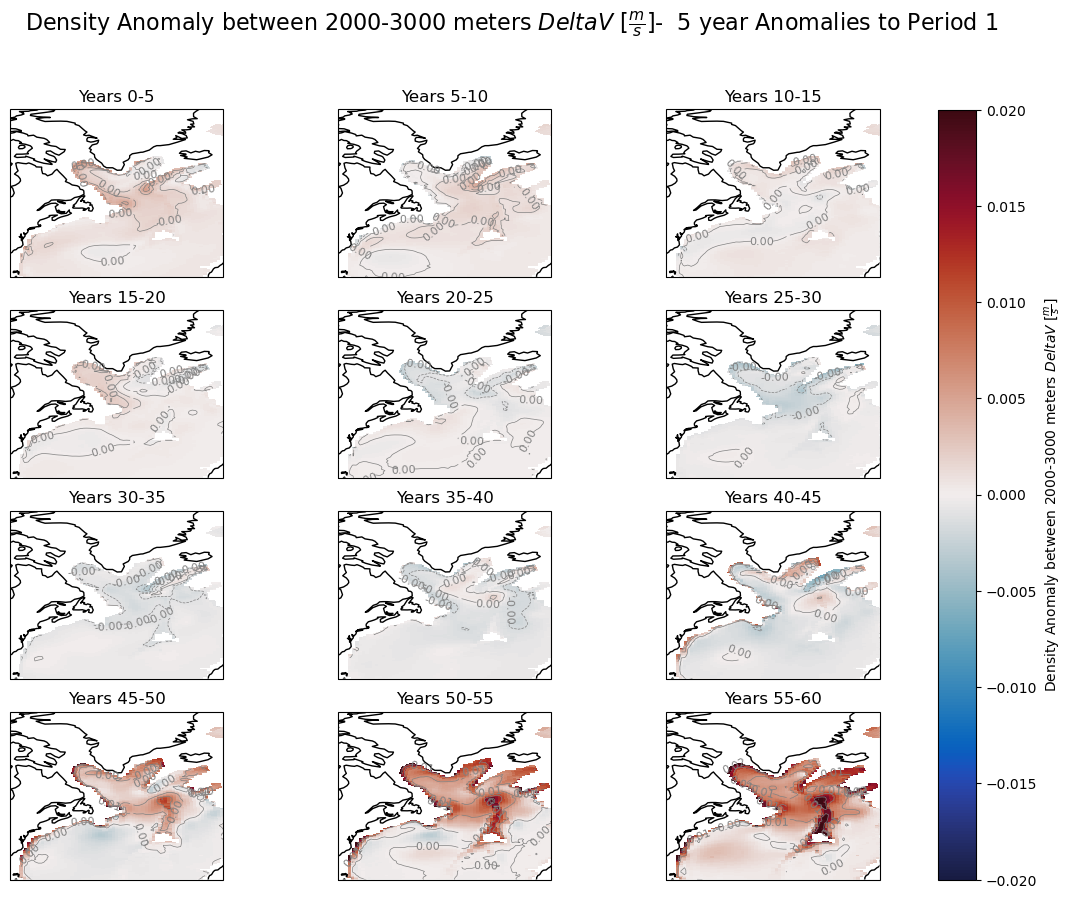

In [11]:
label=r'Density Anomaly between 2000-3000 meters $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']'

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    pc = ds_anom['SIGMA_2'].isel(time=range(i * 5, i * 5 + 5)).mean(dim=['time', 'z_t']).plot.pcolormesh(ax=ax, 
                                                                                    transform=ccrs.PlateCarree(),
                                                                                    x='TLONG', 
                                                                                    y='TLAT',
                                                                                    cmap=cmo.balance,
                                                                                    vmin = vmin, vmax = vmax,
                                                                                    add_colorbar=False,) 
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()
    
    cs = ax.contour(ds_sigma.TLONG, ds_sigma.TLAT, ds_anom['SIGMA_2'].isel(time=range(i * 5, i * 5 + 5)).mean(dim=['time', 'z_t']).where(mask3d == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt='%1.2f', inline=True, fontsize=8)

cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=label)

fig.suptitle(r'Density Anomaly between 2000-3000 meters $Delta V$ [$\frac{m}{s}$]-  5 year Anomalies to Period 1', fontsize=16)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'upper_VVEL_5year_anomalies.png', bbox_inches='tight', dpi=300)    

# Meridional velocity in density layers flip books

In [12]:
# vvel file names
vvel_annual = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/VVELcomposite.nc'
sigma_annual = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sigma_composite_annual.nc'
#load data
ds_vvel = xr.open_dataset(vvel_annual).roll(nlon=+100)
ds_sigma = xr.open_dataset(sigma_annual).roll(nlon=+100)

# chnage units from cm to m
ds_vvel['VVEL'] = ds_vvel.VVEL *1e-2
ds_vvel['VVEL'].attrs['units'] = 'm/s'

vmin, vmax = -0.04,0.04 

In [13]:
ds_vvel_clim = ds_vvel.isel(time=slice(0, 40)).mean('time')
ds_sigma_clim = ds_sigma.isel(time=slice(0, 40)).mean('time')

## For upper density range (trying to catch upper max change in dmoc)

In [14]:
# Define the value range
min_value = 36.20
max_value = 36.30

# Check for NaN values in SIGMA_2 and replace them if necessary
ds_sigma_clim['SIGMA_2'] = ds_sigma_clim['SIGMA_2'].fillna(0)

# Create a mask where SIGMA_2 values are within the specified range
mask = (ds_sigma_clim['SIGMA_2'] >= min_value) & (ds_sigma_clim['SIGMA_2'] <= max_value)

# Use the mask to find the indices
indices_in_range = xr.where(mask, True, False)

In [15]:
ds_anom = ds_vvel - ds_vvel.isel(time=slice(0,40)).mean('time')
ds_anom = ds_anom.where(indices_in_range).mean('z_t')
ds_anom = replace_invalid_T_values(ds_anom)

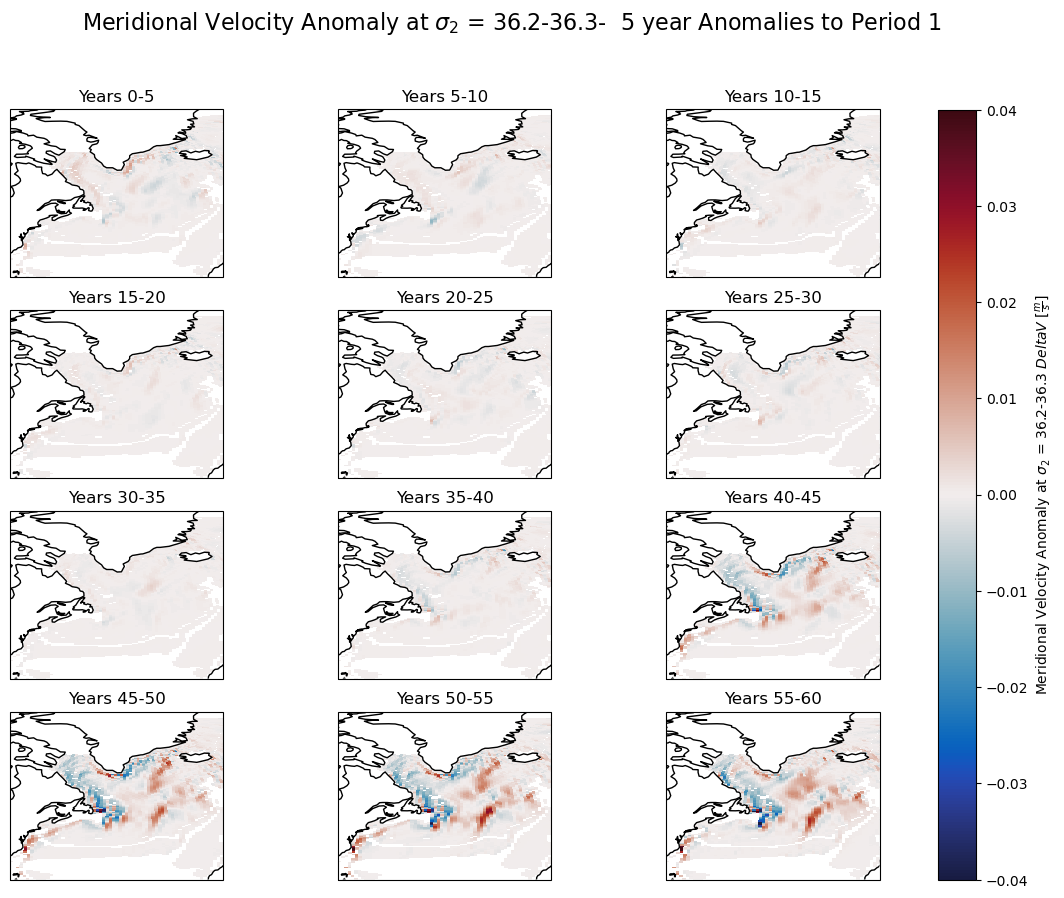

In [16]:
label=r'Meridional Velocity Anomaly at $\sigma_2$ = '+str(min_value)+'-'+str(max_value)+r' $Delta V$ [$\frac{m}{s}$]'

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    pc = ds_anom['VVEL'].isel(time=range(i * 5, i * 5 + 5)).mean(dim=['time']).plot.pcolormesh(ax=ax, 
                                                                                    transform=ccrs.PlateCarree(),
                                                                                    x='TLONG', 
                                                                                    y='TLAT',
                                                                                    cmap=cmo.balance,
                                                                                    vmin = vmin, vmax = vmax,
                                                                                    add_colorbar=False,) 
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()

cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=label)

fig.suptitle(r'Meridional Velocity Anomaly at $\sigma_2$ = '+str(min_value)+'-'+str(max_value)+'-  5 year Anomalies to Period 1', fontsize=16)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'upper_VVEL_5year_anomalies.png', bbox_inches='tight', dpi=300)    

## For lower density range (trying to catch lower max change in dmoc)

In [17]:
# Define the value range
min_value = 36.58
max_value = 36.68

# Check for NaN values in SIGMA_2 and replace them if necessary
ds_sigma_clim['SIGMA_2'] = ds_sigma_clim['SIGMA_2'].fillna(0)

# Create a mask where SIGMA_2 values are within the specified range
mask = (ds_sigma_clim['SIGMA_2'] >= min_value) & (ds_sigma_clim['SIGMA_2'] <= max_value)

# Use the mask to find the indices
indices_in_range = xr.where(mask, True, False)

In [18]:
ds_anom = ds_vvel - ds_vvel.isel(time=slice(0,40)).mean('time')
ds_anom = ds_anom.where(indices_in_range).mean('z_t')
ds_anom = replace_invalid_T_values(ds_anom)

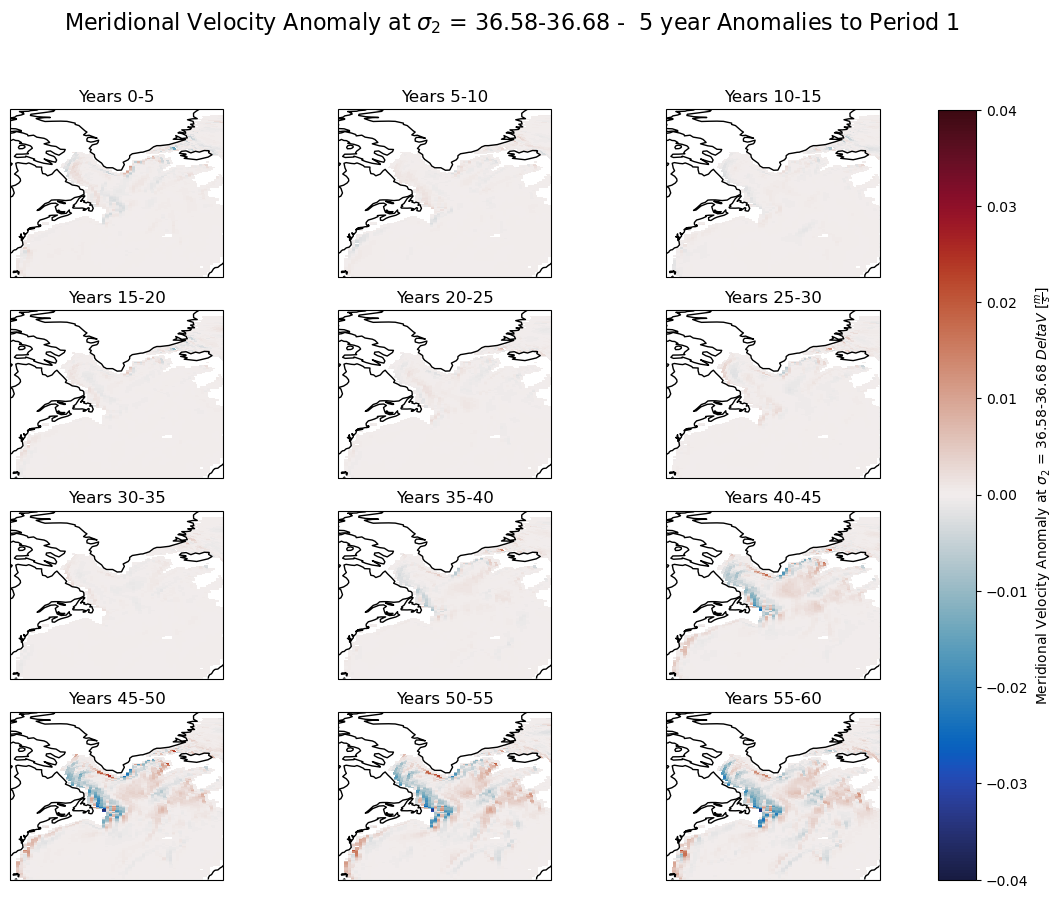

In [19]:
label=r'Meridional Velocity Anomaly at $\sigma_2$ = '+str(min_value)+'-'+str(max_value)+r' $Delta V$ [$\frac{m}{s}$]'

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    pc = ds_anom['VVEL'].isel(time=range(i * 5, i * 5 + 5)).mean(dim=['time']).plot.pcolormesh(ax=ax, 
                                                                                    transform=ccrs.PlateCarree(),
                                                                                    x='TLONG', 
                                                                                    y='TLAT',
                                                                                    cmap=cmo.balance,
                                                                                    vmin = vmin, vmax = vmax,
                                                                                    add_colorbar=False,) 
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())
    ax.set_title(f"Years {(i*5)}-{(i*5)+5}")
    ax.coastlines()

cbar = fig.colorbar(pc, ax=axes, orientation='vertical', label=label)

fig.suptitle(r'Meridional Velocity Anomaly at $\sigma_2$ = '+str(min_value)+'-'+str(max_value)+' -  5 year Anomalies to Period 1', fontsize=16)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'lower_VVEL_5year_anomalies.png', bbox_inches='tight', dpi=300)    

# Making nice flip books

In [4]:
# vvel file names
vvel_annual = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/VVELcomposite.nc'
sigma_annual = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sigma_composite_annual.nc'
#load data
ds_vvel = xr.open_dataset(vvel_annual).roll(nlon=+100)
ds_sigma = xr.open_dataset(sigma_annual).roll(nlon=+100)

# chnage units from cm to m
ds_vvel['VVEL'] = ds_vvel.VVEL *1e-2
ds_vvel['VVEL'].attrs['units'] = 'm/s'

ds_vvel_clim = ds_vvel.isel(time=slice(0, 40)).mean('time')
ds_sigma_clim = ds_sigma.isel(time=slice(0, 40)).mean('time')

#ds_sigma = replace_invalid_T_values(ds_sigma)
#ds_vvel = replace_invalid_U_values(ds_vvel)

Meridional velocity at upper layer

In [36]:
# Define the value range
min_value_1 = 36.10
max_value_1 = 36.30

# Check for NaN values in SIGMA_2 and replace them if necessary
ds_sigma_clim['SIGMA_2'] = ds_sigma_clim['SIGMA_2'].fillna(0)

# Create a mask where SIGMA_2 values are within the specified range
mask = (ds_sigma_clim['SIGMA_2'] >= min_value_1) & (ds_sigma_clim['SIGMA_2'] <= max_value_1)

# Use the mask to find the indices
indices_in_range_1 = xr.where(mask, True, False)

#ds_anom = ds_vvel - ds_vvel.isel(time=slice(0,40)).mean('time')
#ds_anom = replace_invalid_U_values(ds_anom)
#upper_vvel_anom = ds_anom.where(indices_in_range_1).mean('z_t')
#upper_vvel_anom = replace_invalid_U_values(upper_vvel_anom)

ds_anom = ds_vvel - ds_vvel.isel(time=slice(0,40)).mean('time')
ds_anom = ds_anom.where(indices_in_range_1).mean('z_t')
upper_vvel_anom = replace_invalid_U_values(ds_anom)

Meridional velocity at lower layer

In [37]:
# Define the value range
min_value_2 = 36.60
max_value_2 = 36.65

# Check for NaN values in SIGMA_2 and replace them if necessary
ds_sigma_clim['SIGMA_2'] = ds_sigma_clim['SIGMA_2'].fillna(0)

# Create a mask where SIGMA_2 values are within the specified range
mask = (ds_sigma_clim['SIGMA_2'] >= min_value_2) & (ds_sigma_clim['SIGMA_2'] <= max_value_2)

# Use the mask to find the indices
indices_in_range_2 = xr.where(mask, True, False)

#ds_anom = ds_vvel - ds_vvel.isel(time=slice(0,40)).mean('time')
#ds_anom = replace_invalid_U_values(ds_anom)
#lower_vvel_anom = ds_anom.where(indices_in_range_2).mean('z_t')
#lower_vvel_anom = replace_invalid_U_values(lower_vvel_anom)

ds_anom = ds_vvel - ds_vvel.isel(time=slice(0,40)).mean('time')
ds_anom = ds_anom.where(indices_in_range_2).mean('z_t')
lower_vvel_anom = replace_invalid_U_values(ds_anom)

Density anomaly

In [38]:
ds_sigma = replace_invalid_T_values(ds_sigma)
ds_sigma_clim = ds_sigma.isel(time=slice(0, 40)).mean('time')
ds_anom = ds_sigma - ds_sigma_clim
sigma_anom = ds_anom.sel(z_t=slice(1.968944e+05, 3.133405e+05)).mean('z_t')
#sigma_anom = replace_invalid_T_values(sigma_anom)

Isopycnal range

In [39]:
ds_lower_z_t = ds_sigma.roll(nlon=+100)

In [40]:
#ds_lower_z_t = ds_lower_z_t.isel(time=range(start, end)).mean(dim=['time'])

In [41]:
#ds_lower_z_t.z_t.where(indices_in_range).mean('z_t').plot()

Plot

In [45]:
vmins = [-0.025, -0.025, -0.03, -0.03]
cmaps = [cmo.balance, cmo.balance, cmo.deep, cmo.curl_r]
#cmaps = [cmo.balance, cmo.deep, cmo.curl_r]

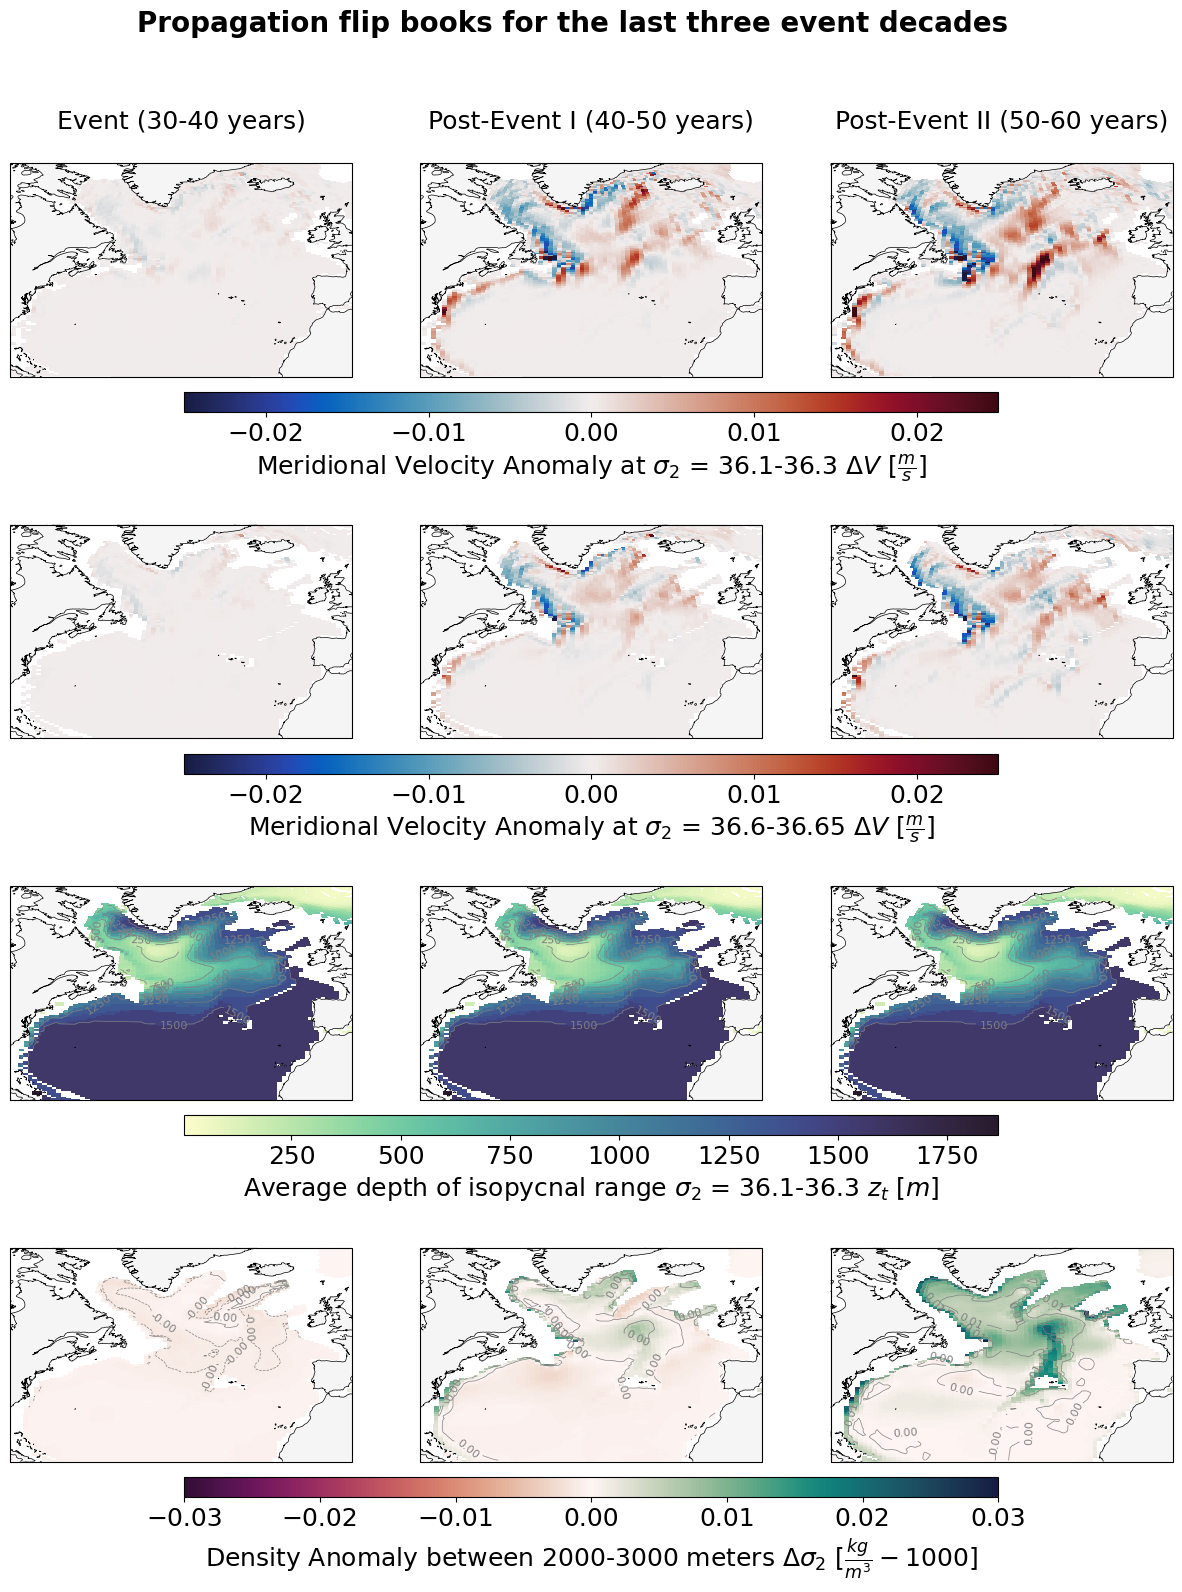

In [48]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 18), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(30, 40), (40, 50), (50, 60)]
column_names = ['Event (30-40 years)', 'Post-Event I (40-50 years)', 'Post-Event II (50-60 years)']
labels = [r'Meridional Velocity Anomaly at $\sigma_2$ = '+str(min_value_1)+'-'+str(max_value_1)+r' $\Delta V$ [$\frac{m}{s}$]', 
          r'Meridional Velocity Anomaly at $\sigma_2$ = '+str(min_value_2)+'-'+str(max_value_2)+r' $\Delta V$ [$\frac{m}{s}$]', 
          r'Average depth of isopycnal range $\sigma_2$ = '+str(min_value_1)+'-'+str(max_value_1)+r' $z_t$ [$m$]', 
          r'Density Anomaly between 2000-3000 meters $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']

row = 0
vmin = vmins[row]
vmax = -vmin
for col, (start, end) in enumerate(years_ranges):
    ax = axes[row, col]
    pc = upper_vvel_anom['VVEL'].isel(time=range(start, end)).mean('time').plot.pcolormesh(
        ax=ax, 
        transform=ccrs.PlateCarree(),
        x='ULONG', 
        y='ULAT',
        cmap=cmaps[row],
        vmin=vmin, vmax=vmax,
        add_colorbar=False
    ) 
    ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
    ax.add_feature(nature_coast)
cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)

row = 1
vmin = vmins[row]
vmax = -vmin
for col, (start, end) in enumerate(years_ranges):
    ax = axes[row, col]
    pc = lower_vvel_anom['VVEL'].isel(time=range(start, end)).mean('time').plot.pcolormesh(
        ax=ax, 
        transform=ccrs.PlateCarree(),
        x='ULONG', 
        y='ULAT',
        cmap=cmaps[row],
        vmin=vmin, vmax=vmax,
        add_colorbar=False
    ) 
    ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
    ax.add_feature(nature_coast)
cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)

row = 2
vmin = vmins[row]
vmax = -vmin
for col, (start, end) in enumerate(years_ranges):
    ax = axes[row, col]
    ds_z_t = ds_lower_z_t.isel(time=range(start, end)).mean(dim=['time'])
    ds_z_t = ds_z_t.z_t.where(indices_in_range_2).mean('z_t')/100
    plotting_data = replace_invalid_T_values(ds_z_t)
    
    pc = plotting_data.plot.pcolormesh(
        ax=ax, 
        transform=ccrs.PlateCarree(),
        x='TLONG', 
        y='TLAT',
        cmap=cmaps[row],
        #vmin=vmin, vmax=vmax,
        add_colorbar=False
    ) 
    
    ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
    ax.add_feature(nature_coast)
    
    cs = ax.contour(ds_sigma.TLONG, ds_sigma.TLAT, plotting_data.where(mask3d == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=8)
    
cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)

row = 3
vmin = vmins[row]
vmax = -vmin
for col, (start, end) in enumerate(years_ranges):
    ax = axes[row, col]
    pc = sigma_anom['SIGMA_2'].isel(time=range(start, end)).mean('time').plot.pcolormesh(
        ax=ax, 
        transform=ccrs.PlateCarree(),
        x='TLONG', 
        y='TLAT',
        cmap=cmaps[row],
        vmin=vmin, vmax=vmax,
        add_colorbar=False
    ) 
    ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
    ax.add_feature(nature_coast)
    cs = ax.contour(ds_sigma.ULONG, ds_sigma.ULAT, sigma_anom['SIGMA_2'].isel(time=range(start, end)).mean(dim=['time']).where(mask3d == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt='%1.2f', inline=True, fontsize=8)
cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle(r'Propagation flip books for the last three event decades', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Propagation.png', bbox_inches='tight', dpi=300)